# This is a Jupyter notebook for David Dobrinskiy's HSE Thesis
## How Venture Capital Affects Startups' Success


In [1]:
# You should be running python3

import sys
print(sys.version)

3.4.4 |Anaconda 2.3.0 (64-bit)| (default, Jan 11 2016, 13:54:01) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
import pandas as pd  # http://pandas.pydata.org/
import numpy as np   # http://numpy.org/

import statsmodels.api as sm  # http://statsmodels.sourceforge.net/stable/index.html
import statsmodels.formula.api as smf
import statsmodels

print("Pandas Version: {}".format(pd.__version__))          # pandas version
print("StatsModels Version: {}".format(statsmodels.__version__))  # StatsModels version

Pandas Version: 0.14.1
StatsModels Version: 0.6.1


### Let us look at the dynamics of total US VC investment

In [3]:
# load the pwc dataset from azure

from azureml import Workspace

ws = Workspace()
ds = ws.datasets['pwc_moneytree.csv']
frame = ds.to_dataframe()

In [4]:
frame.head()

,Quarter,Unnamed: 1,1,2,3,4,Grand Total
0,1995,# of Deals,503,466,434,494,"1,897"
1,NaN,Amount Invested,"$1,690,040,500","$2,546,374,500","$1,709,754,500","$2,070,353,900","$8,016,523,400"
2,1996,# of Deals,585,671,604,775,"2,635"
3,NaN,Amount Invested,"$2,437,964,900","$3,017,298,000","$2,606,841,300","$3,223,318,800","$11,285,423,000"
4,1997,# of Deals,773,778,762,919,"3,232"


In [5]:
del frame['Grand Total']
frame.columns = ['year', 'type', 'q1', 'q2', 'q3', 'q4']
frame['year'] = frame['year'].fillna(method='ffill')
frame.head()

,year,type,q1,q2,q3,q4
0,1995,# of Deals,503,466,434,494
1,1995,Amount Invested,"$1,690,040,500","$2,546,374,500","$1,709,754,500","$2,070,353,900"
2,1996,# of Deals,585,671,604,775
3,1996,Amount Invested,"$2,437,964,900","$3,017,298,000","$2,606,841,300","$3,223,318,800"
4,1997,# of Deals,773,778,762,919


Deals and investments are in alternating rows of **frame**, let's separate them

In [6]:
      deals_df = frame.iloc[0::2]
investments_df = frame.iloc[1::2]

In [7]:
# once separated, 'type' field is identical within each df
# let's delete it

del       deals_df['type']
del investments_df['type']

In [8]:
deals_df.head()

,year,q1,q2,q3,q4
0,1995,503,466,434,494
2,1996,585,671,604,775
4,1997,773,778,762,919
6,1998,871,912,931,"1,030"
8,1999,936,"1,330","1,448","1,892"


In [9]:
investments_df.head()

,year,q1,q2,q3,q4
1,1995,"$1,690,040,500","$2,546,374,500","$1,709,754,500","$2,070,353,900"
3,1996,"$2,437,964,900","$3,017,298,000","$2,606,841,300","$3,223,318,800"
5,1997,"$3,104,430,200","$3,691,566,400","$3,775,959,100","$4,499,598,900"
7,1998,"$4,199,545,200","$5,784,400,500","$5,412,295,700","$6,165,090,000"
9,1999,"$6,648,622,700","$11,315,434,200","$13,654,453,100","$23,340,087,500"


In [10]:
def unstack_to_series(df):
    """
    Takes q1-q4 in a dataframe and converts it to a series
    
    input: a dataframe containing ['q1', 'q2', 'q3', 'q4']
    
    ouput: a pandas series
    """
    quarters = ['q1', 'q2', 'q3', 'q4']
    d = dict()
    for i, row in df.iterrows():
        for q in quarters:
            key = str(int(row['year'])) + q
            d[key] = row[q]

            # print(key, q, row[q])
    return pd.Series(d)

In [11]:
      deals = unstack_to_series(deals_df      ).dropna()
investments = unstack_to_series(investments_df).dropna()

In [12]:
def string_to_int(money_string):
    numerals = [c if c.isnumeric() else '' for c in money_string]
    return int(''.join(numerals))

In [13]:
# convert deals from string to integers
deals = deals.apply(string_to_int)
deals.tail()

2015q3    1189
2015q4    1047
2016q1    1021
2016q2     999
2016q3     891
dtype: int64

In [14]:
# investment in billions USD
# converts to integers - which is ok, since data is in dollars
investments_b = investments.apply(string_to_int) 
# in python3 division automatically converts numbers to floats, we don't loose precicion
investments_b = investments_b / 10**9
# round data to 2 decimals
investments_b = investments_b.apply(round, ndigits=2)
investments_b.tail()

2015q3    16.71
2015q4    12.34
2016q1    12.64
2016q2    15.57
2016q3    10.63
dtype: float64

### Plot data from MoneyTree report

http://www.pwcmoneytree.com

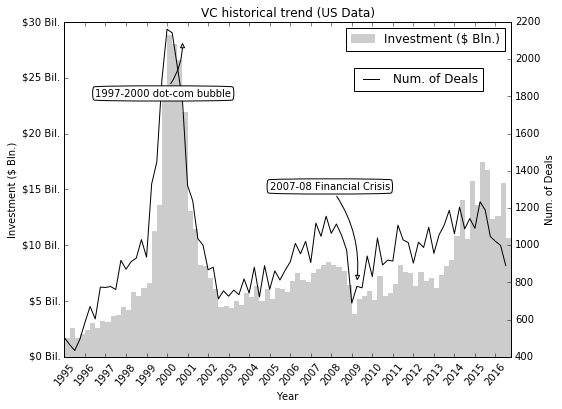

In [15]:
import matplotlib.pyplot  as plt  # http://matplotlib.org/
import matplotlib.patches as mpatches
import matplotlib.ticker  as ticker
%matplotlib inline

# change matplotlib inline display size
# import matplotlib.pylab as pylab
# pylab.rcParams['figure.figsize'] = (8, 6)  # that's default image size for this interactive session

fig, ax1 = plt.subplots()
ax1.set_title("VC historical trend (US Data)")
t = range(len(investments_b))      # need to substitute tickers for years later
width = t[1]-t[0]
y1 = investments_b

# create filled step chart for investment amount
ax1.bar(t, y1, width=width, facecolor='0.80', edgecolor='', label = 'Investment ($ Bln.)')
ax1.set_ylabel('Investment ($ Bln.)')

# set up xlabels with years
years = [str(year)[:-2] for year in deals.index][::4]  # get years without quarter 
ax1.set_xticks(t[::4])                   # set 1 tick per year
ax1.set_xticklabels(years, rotation=50)  # set tick names
ax1.set_xlabel('Year')                   # name X axis

# format Y1 tickers to $ billions
formatter = ticker.FormatStrFormatter('$%1.0f Bil.')
ax1.yaxis.set_major_formatter(formatter)
for tick in ax1.yaxis.get_major_ticks():
    tick.label1On = False
    tick.label2On = True

# create second Y2 axis for Num of Deals
ax2 = ax1.twinx()
y2 = deals
ax2.plot(t, y2, color = 'k', ls = '-', label = 'Num. of Deals')
ax2.set_ylabel('Num. of Deals')

# add annotation bubbles
ax2.annotate('1997-2000 dot-com bubble', xy=(23, 2100), xytext=(6, 1800),
                bbox=dict(boxstyle="round4", fc="w"),
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3,rad=0.2",
                                fc="w"),
            )

ax2.annotate('2007-08 Financial Crisis', xy=(57, 800), xytext=(40, 1300),
                bbox=dict(boxstyle="round4", fc="w"),
                arrowprops=dict(arrowstyle="-|>",
                                connectionstyle="arc3,rad=-0.2",
                                fc="w"), 
            )


# add legend
ax1.legend(loc="best")
ax2.legend(bbox_to_anchor=(0.95, 0.88))

fig.tight_layout()  # solves cropping problems when saving png
fig.savefig('vc_trend_3.png', dpi=250)


plt.show()

In [16]:
# load countries dataset from azure
ds = ws.datasets['country_data.csv']

In [17]:
# data for 2015
country_data = ds.to_dataframe()
country_data

,Criteria,USA,Canada,Russia
0,Growth rate of profitability of start-ups in 2...,3.500,1.700,0.900
1,"Index of innovative development for 2015, %",59.400,66.600,61.400
2,State participation in activities of start-ups,0.199,0.222,0.210
3,Development of basic researches,0.194,0.194,0.151
4,Development of objects of innovative infrastru...,0.148,0.166,0.148
5,Support of innovative business of start-ups,0.066,0.083,0.083
6,"Tax, credit, budget incentives of innovative a...",0.044,0.044,0.051
7,Development of venture capital of start-ups,0.087,0.108,0.108
8,Legal support of innovative activities of star...,0.109,0.136,0.136
9,Integration into world innovative system,0.026,0.027,0.027


In [18]:
def tex(df):
    """
    Print dataframe contents in latex-ready format
    """
    for line in df.to_latex().split('\n'):
        print(line)

In [19]:
params = pd.DataFrame(country_data['Criteria'])
params.index = ['y'] + ['X'+str(i) for i in range(1, len(country_data))]
tex(params)

\begin{tabular}{ll}
\toprule
{} &                                           Criteria \\
\midrule
y  &  Growth rate of profitability of start-ups in 2... \\
X1 &        Index of innovative development for 2015, \% \\
X2 &     State participation in activities of start-ups \\
X3 &                    Development of basic researches \\
X4 &  Development of objects of innovative infrastru... \\
X5 &        Support of innovative business of start-ups \\
X6 &  Tax, credit, budget incentives of innovative a... \\
X7 &        Development of venture capital of start-ups \\
X8 &  Legal support of innovative activities of star... \\
X9 &           Integration into world innovative system \\
\bottomrule
\end{tabular}



In [20]:
# set index
country_data = country_data.set_index('Criteria')
# convert values to floats (note: comas need to be replaced by dots for python conversion to work)
country_data.index = ['y'] + ['X'+str(i) for i in range(1, len(country_data))]
country_data

,USA,Canada,Russia
y,3.500,1.700,0.900
X1,59.400,66.600,61.400
X2,0.199,0.222,0.210
X3,0.194,0.194,0.151
X4,0.148,0.166,0.148
X5,0.066,0.083,0.083
X6,0.044,0.044,0.051
X7,0.087,0.108,0.108
X8,0.109,0.136,0.136
X9,0.026,0.027,0.027


# prepare data for ols

In [21]:
const = pd.Series([1]*len(country_data.columns), index = country_data.columns, name = 'X0')
const

USA       1
Canada    1
Russia    1
Name: X0, dtype: int64

In [22]:
country_data = pd.concat([pd.DataFrame(const).T, country_data])
country_data = country_data.sort_index()
country_data

,USA,Canada,Russia
X0,1.000,1.000,1.000
X1,59.400,66.600,61.400
X2,0.199,0.222,0.210
X3,0.194,0.194,0.151
X4,0.148,0.166,0.148
X5,0.066,0.083,0.083
X6,0.044,0.044,0.051
X7,0.087,0.108,0.108
X8,0.109,0.136,0.136
X9,0.026,0.027,0.027


In [23]:
tex(country_data)

\begin{tabular}{lrrr}
\toprule
{} &     USA &  Canada &  Russia \\
\midrule
X0 &   1.000 &   1.000 &   1.000 \\
X1 &  59.400 &  66.600 &  61.400 \\
X2 &   0.199 &   0.222 &   0.210 \\
X3 &   0.194 &   0.194 &   0.151 \\
X4 &   0.148 &   0.166 &   0.148 \\
X5 &   0.066 &   0.083 &   0.083 \\
X6 &   0.044 &   0.044 &   0.051 \\
X7 &   0.087 &   0.108 &   0.108 \\
X8 &   0.109 &   0.136 &   0.136 \\
X9 &   0.026 &   0.027 &   0.027 \\
y  &   3.500 &   1.700 &   0.900 \\
\bottomrule
\end{tabular}



In [24]:
y = country_data.iloc[-1,:]
y

USA       3.5
Canada    1.7
Russia    0.9
Name: y, dtype: float64

In [25]:
X = country_data.iloc[:-1, :].T
X

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9
USA,1,59.4,0.199,0.194,0.148,0.066,0.044,0.087,0.109,0.026
Canada,1,66.6,0.222,0.194,0.166,0.083,0.044,0.108,0.136,0.027
Russia,1,61.4,0.210,0.151,0.148,0.083,0.051,0.108,0.136,0.027


In [26]:
# Fit regression model
results = sm.OLS(y, X).fit()

# Inspect the results in latex doc, {tab:vc_ols_1}
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Mon, 14 Nov 2016   Prob (F-statistic):                nan
Time:                        14:32:11   Log-Likelihood:                 83.470
No. Observations:                   3   AIC:                            -160.9
Df Residuals:                       0   BIC:                            -163.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
X0             8.6385        inf          0        n

/home/nbuser/env3/lib/python3.4/site-packages/statsmodels/stats/stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  "samples were given." % int(n))


In [27]:
# Inspect the results in latex doc, {tab:vc_ols_1}
print(results.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &        y         & \textbf{  R-squared:         } &     1.000   \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &       nan   \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &     0.000   \\
\textbf{Date:}             & Mon, 14 Nov 2016 & \textbf{  Prob (F-statistic):} &      nan    \\
\textbf{Time:}             &     14:32:12     & \textbf{  Log-Likelihood:    } &    83.470   \\
\textbf{No. Observations:} &           3      & \textbf{  AIC:               } &    -160.9   \\
\textbf{Df Residuals:}     &           0      & \textbf{  BIC:               } &    -163.6   \\
\textbf{Df Model:}         &           2      & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lccccc}
            & \textbf{coef} & \textbf{std err} & \textbf{t} & \textbf{P$>$$|$t$|$} & \textbf{[95.0\% Conf. Int.]}  \\
\midrule
\textbf{X

/home/nbuser/env3/lib/python3.4/site-packages/statsmodels/stats/stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  "samples were given." % int(n))


In [28]:
# equation for eq:OLS_1_coeffs in LaTeX

equation = 'Y ='
for i, coeff in results.params.iteritems():
    sign = '+' if coeff >= 0 else '-'
    equation += ' ' + sign + str(abs(round(coeff,2))) + '*' + i
print(equation)

Y = +8.64*X0 -0.13*X1 -3.32*X2 +33.34*X3 +3.68*X4 -9.68*X5 -4.78*X6 -11.92*X7 -15.34*X8 -0.38*X9


In [29]:
# correlation table
corr = country_data.T.corr().iloc[1:,1:]
corr = corr.applymap(lambda x: round(x, 2))
corr

,X1,X2,X3,X4,X5,X6,X7,X8,X9,y
X1,1.00,0.97,0.25,0.96,0.71,-0.25,0.71,0.71,0.71,-0.47
X2,0.97,1.00,0.03,0.88,0.85,-0.03,0.85,0.85,0.85,-0.66
X3,0.25,0.03,1.00,0.50,-0.50,-1.00,-0.50,-0.50,-0.50,0.74
X4,0.96,0.88,0.50,1.00,0.50,-0.50,0.50,0.50,0.50,-0.22
X5,0.71,0.85,-0.50,0.50,1.00,0.50,1.00,1.00,1.00,-0.95
X6,-0.25,-0.03,-1.00,-0.50,0.50,1.00,0.50,0.50,0.50,-0.74
X7,0.71,0.85,-0.50,0.50,1.00,0.50,1.00,1.00,1.00,-0.95
X8,0.71,0.85,-0.50,0.50,1.00,0.50,1.00,1.00,1.00,-0.95
X9,0.71,0.85,-0.50,0.50,1.00,0.50,1.00,1.00,1.00,-0.95
y,-0.47,-0.66,0.74,-0.22,-0.95,-0.74,-0.95,-0.95,-0.95,1.00


In [30]:
# corr table to latex
tex(corr)

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &    X1 &    X2 &    X3 &    X4 &    X5 &    X6 &    X7 &    X8 &    X9 &     y \\
\midrule
X1 &  1.00 &  0.97 &  0.25 &  0.96 &  0.71 & -0.25 &  0.71 &  0.71 &  0.71 & -0.47 \\
X2 &  0.97 &  1.00 &  0.03 &  0.88 &  0.85 & -0.03 &  0.85 &  0.85 &  0.85 & -0.66 \\
X3 &  0.25 &  0.03 &  1.00 &  0.50 & -0.50 & -1.00 & -0.50 & -0.50 & -0.50 &  0.74 \\
X4 &  0.96 &  0.88 &  0.50 &  1.00 &  0.50 & -0.50 &  0.50 &  0.50 &  0.50 & -0.22 \\
X5 &  0.71 &  0.85 & -0.50 &  0.50 &  1.00 &  0.50 &  1.00 &  1.00 &  1.00 & -0.95 \\
X6 & -0.25 & -0.03 & -1.00 & -0.50 &  0.50 &  1.00 &  0.50 &  0.50 &  0.50 & -0.74 \\
X7 &  0.71 &  0.85 & -0.50 &  0.50 &  1.00 &  0.50 &  1.00 &  1.00 &  1.00 & -0.95 \\
X8 &  0.71 &  0.85 & -0.50 &  0.50 &  1.00 &  0.50 &  1.00 &  1.00 &  1.00 & -0.95 \\
X9 &  0.71 &  0.85 & -0.50 &  0.50 &  1.00 &  0.50 &  1.00 &  1.00 &  1.00 & -0.95 \\
y  & -0.47 & -0.66 &  0.74 & -0.22 & -0.95 & -0.74 & -0.95 & -0.95 & -0.95 &  1.00 \\
\bottom

In [31]:
import itertools
# set of unique parameter pairs
pairs = set([frozenset(pair) for pair in itertools.permutations(list(corr.index), 2)]) 
for pair in pairs:
    pair = sorted(list(pair))
    corr_pair = corr.loc[pair[0],pair[1]]
    if corr_pair > 0.7:
        print(pair, round(corr_pair, 2))
        print('-'*40)

['X2', 'X8'] 0.85
----------------------------------------
['X1', 'X2'] 0.97
----------------------------------------
['X8', 'X9'] 1.0
----------------------------------------
['X1', 'X8'] 0.71
----------------------------------------
['X5', 'X9'] 1.0
----------------------------------------
['X1', 'X5'] 0.71
----------------------------------------
['X1', 'X4'] 0.96
----------------------------------------
['X1', 'X7'] 0.71
----------------------------------------
['X2', 'X9'] 0.85
----------------------------------------
['X7', 'X8'] 1.0
----------------------------------------
['X7', 'X9'] 1.0
----------------------------------------
['X2', 'X4'] 0.88
----------------------------------------
['X5', 'X7'] 1.0
----------------------------------------
['X5', 'X8'] 1.0
----------------------------------------
['X2', 'X7'] 0.85
----------------------------------------
['X2', 'X5'] 0.85
----------------------------------------
['X1', 'X9'] 0.71
----------------------------------------
['X

In [32]:
print('a')

a


In [33]:
for i in corr.columns:
    for j in corr.columns:
        if abs(corr.loc[i, j]) > 0.7 and i != j:
            print(i+'~'+j, corr.loc[i, j])

X1~X2 0.97
X1~X4 0.96
X1~X5 0.71
X1~X7 0.71
X1~X8 0.71
X1~X9 0.71
X2~X1 0.97
X2~X4 0.88
X2~X5 0.85
X2~X7 0.85
X2~X8 0.85
X2~X9 0.85
X3~X6 -1.0
X3~y 0.74
X4~X1 0.96
X4~X2 0.88
X5~X1 0.71
X5~X2 0.85
X5~X7 1.0
X5~X8 1.0
X5~X9 1.0
X5~y -0.95
X6~X3 -1.0
X6~y -0.74
X7~X1 0.71
X7~X2 0.85
X7~X5 1.0
X7~X8 1.0
X7~X9 1.0
X7~y -0.95
X8~X1 0.71
X8~X2 0.85
X8~X5 1.0
X8~X7 1.0
X8~X9 1.0
X8~y -0.95
X9~X1 0.71
X9~X2 0.85
X9~X5 1.0
X9~X7 1.0
X9~X8 1.0
X9~y -0.95
y~X3 0.74
y~X5 -0.95
y~X6 -0.74
y~X7 -0.95
y~X8 -0.95
y~X9 -0.95
